In [86]:
from wgangp.db_utils import *
from acf_utils import *
from utility import *

In [147]:
run = 37
number = 1000
mpl.rcParams.update({'font.size': 22})
os.mkdir(f'plots/wgangp_{run}')

FileExistsError: [Errno 17] File exists: 'plots/wgangp_37'

In [148]:
path = f'/scratch/scarpolini/lagrangian/wgangp/runs/{run}/{number}_gen.h5'
gen = load_model(path)
trajs = gen.predict(np.random.normal(0, 1, size=(50000, 100)))
np.save(f'wgangp/runs/{run}/gen_trajs_{number}', trajs)

W0719 13:15:15.047640 47138651368960 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [149]:
path = f'/scratch/scarpolini/lagrangian/wgangp/runs/{run}/gen_trajs_{number}.npy'
gen = np.load(path)

M = gen.max()
m = gen.min()
print('massimo, minimo: ',M,m)

#db = np.load('/scratch/scarpolini/databases/velocities.npy')[:,:,0]
#M = db.max() 
M = 10.273698864467972
#m = db.min()
m = -9.970374739869616
semidisp = (M-m)/2.
media = (M+m)/2.
gen = gen*semidisp + media
print('veri',M,m)
M = gen.max()
m = gen.min()
print('generati',M,m)

massimo, minimo:  0.7482638 -0.8275567
veri 10.273698864467972 -9.970374739869616
generati 7.7256155 -8.224898


In [150]:
gen.shape

(50000, 2000, 1)

# PDF V_x e A_x

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


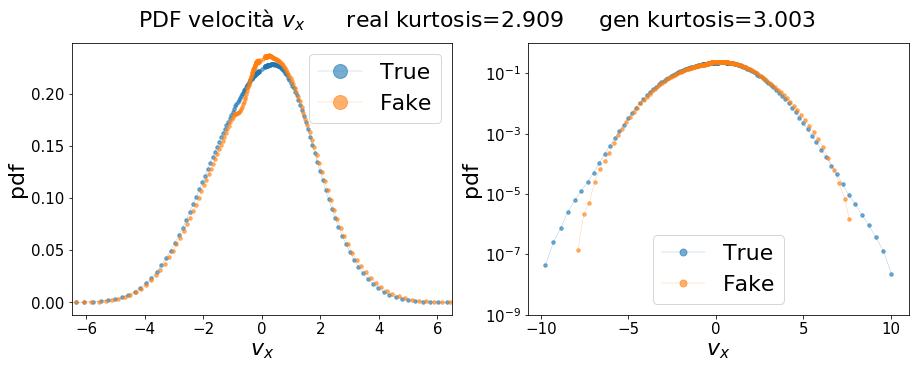

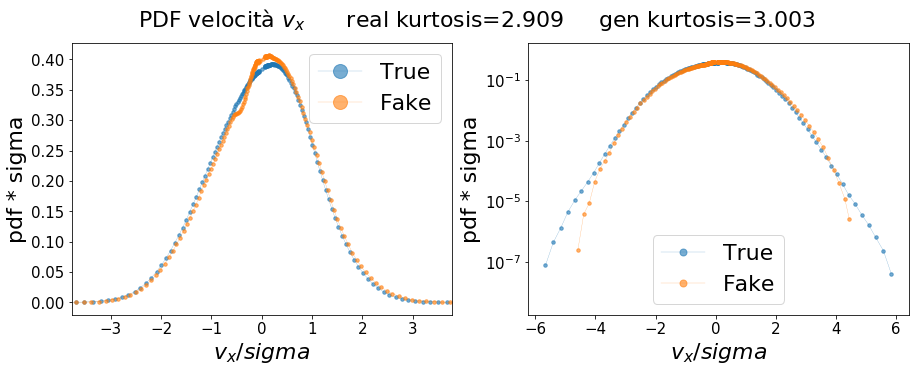

In [151]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fign, (ax1n, ax2n) = plt.subplots(1,2,figsize=(15,5))
hist, bin_edges = load_pdf('data/pdf_vx')
kurtosis_real = kurtosis(bin_edges, hist)
ax1.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
# normalizzate
vel_std = 1.7192559430218903
hist *= vel_std
bin_edges /= vel_std
ax1n.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2n.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)

bins=create_log_bins(gen.min(),gen.max(),200,1e-1)
hist, bin_edges = np.histogram(gen.flatten(), bins=bins, density=True)
for i in range(len(hist)):
    bin_edges[i] = (bin_edges[i]+bin_edges[i+1])/2.
kurtosis_gen = kurtosis(bin_edges, hist)
bin_edges = bin_edges[:-1]
ax1.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
# normalizzate
hist *= vel_std
bin_edges /= vel_std
ax1n.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2n.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)

fig.suptitle(f'PDF velocità $v_x$\treal kurtosis={kurtosis_real:.3f}\tgen kurtosis={kurtosis_gen:.3f}')
fign.suptitle(f'PDF velocità $v_x$\treal kurtosis={kurtosis_real:.3f}\tgen kurtosis={kurtosis_gen:.3f}')

ax1.set_xlabel('$v_x$')
ax1.set_ylabel('pdf')
ax1.set_xlim([-6.5,6.5])
ax1.legend(markerscale=4)
ax2.set_xlabel('$v_x$')
ax2.set_yscale('log')
ax2.set_ylim([1e-9,1])
ax2.set_ylabel('pdf')
ax2.legend(markerscale=2)

ax1n.set_xlabel('$v_x / sigma$')
ax1n.set_ylabel('pdf * sigma')
ax1n.set_xlim([-6.5/vel_std,6.5/vel_std])
ax1n.legend(markerscale=4)
ax2n.set_xlabel('$v_x / sigma$')
ax2n.set_yscale('log')
ax2n.set_ylim([1e-9*vel_std,1*vel_std])
ax2n.set_ylabel('pdf * sigma')
ax2n.legend(markerscale=2)

fig.savefig(f'plots/wgangp_{run}/gan_test_d0_{run}_{number}.png', fmt='png', dpi=100)
fign.savefig(f'plots/wgangp_{run}/gan_test_d0_{run}_{number}_n.png', fmt='png', dpi=100)
fig.show()
fign.show()

In [152]:
gm = np.gradient(gen,axis=1)

1.0017092626771908
1.0072327353048103


/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


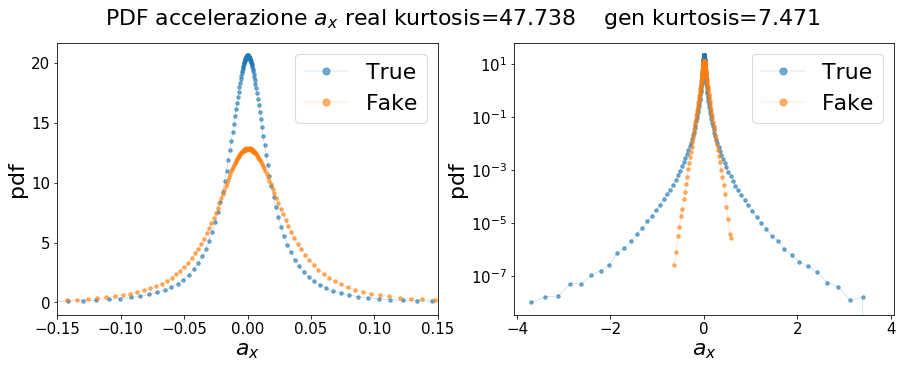

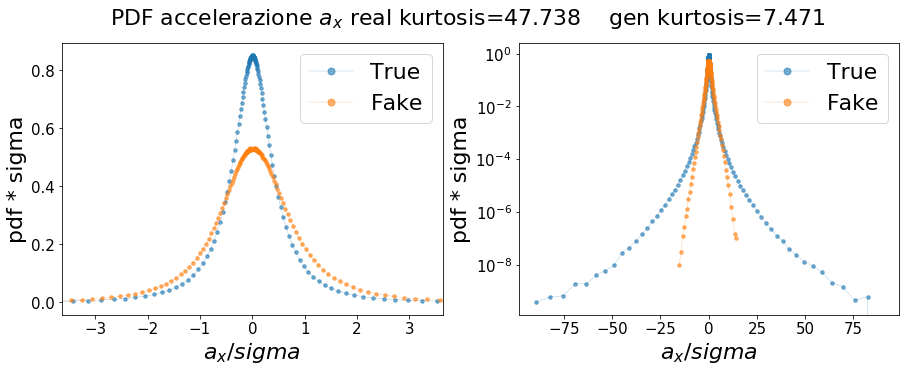

In [153]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fign, (ax1n, ax2n) = plt.subplots(1,2,figsize=(15,5))

hist, bin_edges = load_pdf('data/pdf_ax')
a = 0.
for i in range(len(bin_edges)-1):
    a += hist[i]*(bin_edges[i+1]-bin_edges[i])
print(a)
kurtosis_real = kurtosis(bin_edges, hist)
ax1.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
# normalizzate
acc_std = 0.0412815564714219
hist = hist * acc_std
bin_edges = bin_edges / acc_std
ax1n.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2n.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)

bins=create_log_bins(gm.min(),gm.max(),200,1e-3)
hist, bin_edges = np.histogram(gm.flatten(), bins=bins, density=True)
for i in range(len(hist)):
    bin_edges[i] = (bin_edges[i]+bin_edges[i+1])/2.
kurtosis_gen = kurtosis(bin_edges, hist)
bin_edges = bin_edges[:-1]
a = 0.
for i in range(len(bin_edges)-1):
    a += hist[i]*(bin_edges[i+1]-bin_edges[i])
print(a)
ax1.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
# normalizzate
hist = hist * acc_std
bin_edges = bin_edges / acc_std
ax1n.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2n.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)

fig.suptitle(f'PDF accelerazione $a_x$\treal kurtosis={kurtosis_real:.3f}\tgen kurtosis={kurtosis_gen:.3f}')
fign.suptitle(f'PDF accelerazione $a_x$\treal kurtosis={kurtosis_real:.3f}\tgen kurtosis={kurtosis_gen:.3f}')

ax1.legend(markerscale=2)
ax1.set_xlabel('$a_x$')
ax1.set_ylabel('pdf')
ax1.set_xlim([-0.15,0.15])
ax2.legend(markerscale=2)
ax2.set_xlabel('$a_x$')
ax2.set_ylabel('pdf')
ax2.set_yscale('log')

ax1n.legend(markerscale=2)
ax1n.set_xlabel('$a_x / sigma$')
ax1n.set_ylabel('pdf * sigma')
ax1n.set_xlim([-0.15/acc_std,0.15/acc_std])
ax2n.legend(markerscale=2)
ax2n.set_xlabel('$a_x / sigma$')
ax2n.set_ylabel('pdf * sigma')
ax2n.set_yscale('log')

fig.savefig(f'plots/wgangp_{run}/gan_test_d1_{run}_{number}.png', fmt='png', dpi=100)
fign.savefig(f'plots/wgangp_{run}/gan_test_d1_{run}_{number}_n.png', fmt='png', dpi=100)
fig.show()
fign.show()

# ACF_x

In [ ]:
mean = np.load('../databases/velocities_acf_mean_and_std.npy')[0,:,0]
std = np.load('../databases/velocities_acf_mean_and_std.npy')[1,:,0]
plt.figure(figsize=(8,6))
l, caps, c = plt.errorbar(np.arange(2000), mean, std, lw=0, marker='^', errorevery=40,
                          ms=2, elinewidth=1, uplims=True, lolims=True, capsize=2, label='Real')
for cap in caps:
    cap.set_marker("_")

try: acfs = np.load(f'data/acf_x_gen_{run}_{number}.npy')
except:
    acfs = acf_gen_x(gen)
    np.save(f'data/acf_x_gen_{run}_{number}',acfs)
    
mean = acfs.mean(axis=0)
std = acfs.std(axis=0)
l, caps, c = plt.errorbar(np.arange(2000), mean, std, lw=0, marker='^', errorevery=40,
                          ms=2, elinewidth=1, uplims=True, lolims=True, capsize=2, label='Fake')
for cap in caps:
    cap.set_marker("_")

plt.title('funzione autocorrelazione particelle lagrangiane x')
plt.xlim([0,2000])
plt.xlabel('tau')
plt.legend()
plt.ylabel('autocorrelazione')
plt.savefig(f'plots/wgangp_{run}/gan_test_acfx_{run}_{number}.png', fmt='png', dpi=100)
plt.show()

# ACF$_x$ accelerazione

In [13]:
#mean = np.load('../databases/accelerations_acf_mean_and_std.npy')[0,:,0]
#std = np.load('../databases/accelerations_acf_mean_and_std.npy')[1,:,0]
#plt.figure(figsize=(8,6))
#l, caps, c = plt.errorbar(np.arange(2000), mean, std, lw=0, marker='^', errorevery=40,
#                          ms=2, elinewidth=1, uplims=True, lolims=True, capsize=2, label='Real')
#for cap in caps:
#    cap.set_marker("_")
#
try: acfs = np.load(f'data/acf_x_gen_{run}_{number}_acc.npy')
except:
    acfs = acf_gen_x(gm)
    np.save(f'data/acf_x_gen_{run}_{number}_acc',acfs)

plt.figure(figsize=(8,6))
mean = acfs.mean(axis=0)
std = acfs.std(axis=0)
l, caps, c = plt.errorbar(np.arange(2000), mean, std, lw=0, marker='^', errorevery=40,
                          ms=2, elinewidth=1, uplims=True, lolims=True, capsize=2, label='Fake')
for cap in caps:
    cap.set_marker("_")

plt.title('auto-corr. accelerazione lagrangiane x')
plt.xlim([0,2000])
plt.xlabel('tau')
plt.legend()
plt.ylabel('auto-corr.')
plt.savefig(f'plots/wgangp_{run}/gan_test_acfx_acc_{run}_{number}.png', fmt='png', dpi=100)
plt.show()

KeyboardInterrupt: 

# Exit time

In [12]:
paths = [f'data/acf_x_gen_{run}_{number}.npy']
try: exit_times = np.load(f'data/exit_time_x_gen_{run}_{number}.npy')
except:
    exit_times = gen_exit_time(run, number, 0.5)
    np.save(f'data/exit_time_x_gen_{run}_{number}',exit_times)

FileNotFoundError: [Errno 2] No such file or directory: 'data/acf_x_gen_34_4750.npy'

In [ ]:
plt.figure(figsize=(5,5))
#exit_times = np.load('../databases/exit_time_0.50_lagrangian.npy')
#hist, bin_edges = np.histogram(exit_times,bins=100, density=True)
#print(save_pdf(bin_edges, hist, 'data/pdf_exit_time'))
hist, bin_edges = load_pdf('data/pdf_exit_time')
plt.plot(bin_edges, hist, alpha=0.6, label='True', marker='.', lw=0.3, ms=7)
hist, bin_edges = np.histogram(exit_times, bins=200, density=True)
for i in range(len(hist)):
    bin_edges[i] = (bin_edges[i]+bin_edges[i+1])/2.
bin_edges = bin_edges[:-1]
plt.plot(bin_edges, hist, alpha=0.6, label='Fake', marker='.', lw=0.3, ms=7)
#plt.yscale('log')
plt.title('Exit time PDF')
plt.ylabel('pdf')
plt.xlabel('exit_time')
plt.xlim([0,750])
plt.legend()
plt.savefig(f'plots/wgangp_{run}/gan_test_exit_time_{run}_{number}.png',fmt='png',dpi=100)

# Plot Traiettorie Generate e Reali

In [143]:
db = np.load('../databases/velocities.npy')[:,:,0]

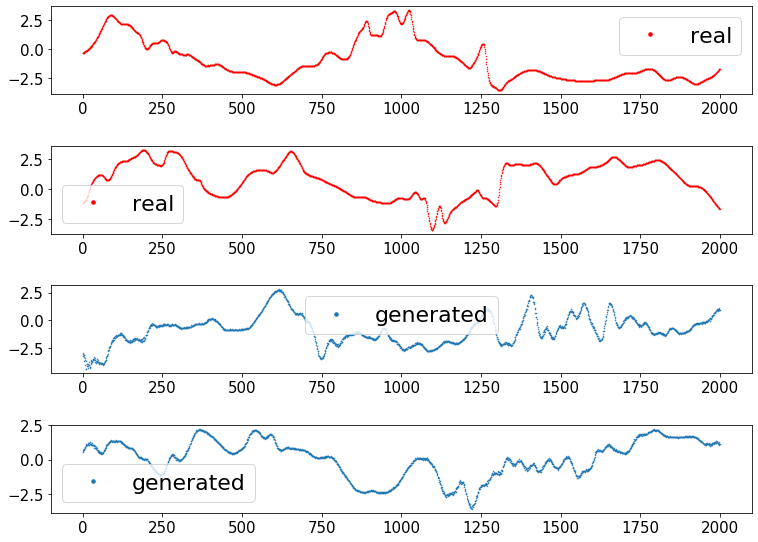

In [154]:
idx1 = np.random.randint(0, db.shape[0], 2)
idx2 = np.random.randint(0, gen.shape[0], 2)
trajs = db[idx1]
gen_trajs = gen[idx2]
plt.figure(figsize=(11, 2*len(trajs)+2*len(gen_trajs)))
plt.title('esempi di velocità vere e generate')

for i, traj in enumerate(trajs):
    plt.subplot(len(trajs)+len(gen_trajs), 1, i+1)
    plt.plot(traj, color='red', label='real', lw=0, marker='.',ms=1)
    plt.legend(markerscale=7)

for i, traj in enumerate(gen_trajs):
    plt.subplot(len(trajs)+len(gen_trajs), 1, i+1+len(trajs))
    plt.plot(traj, label='generated', lw=0, marker='.',ms=1)
    plt.legend(markerscale=7)

plt.tight_layout()
plt.savefig(f'plots/wgangp_{run}/gan_test_trajs_{run}_{number}.png', fmt='png', dpi=100)
plt.show()

[29230 15489 43454 47319 14165  7703 32126 24200 27151 25211]


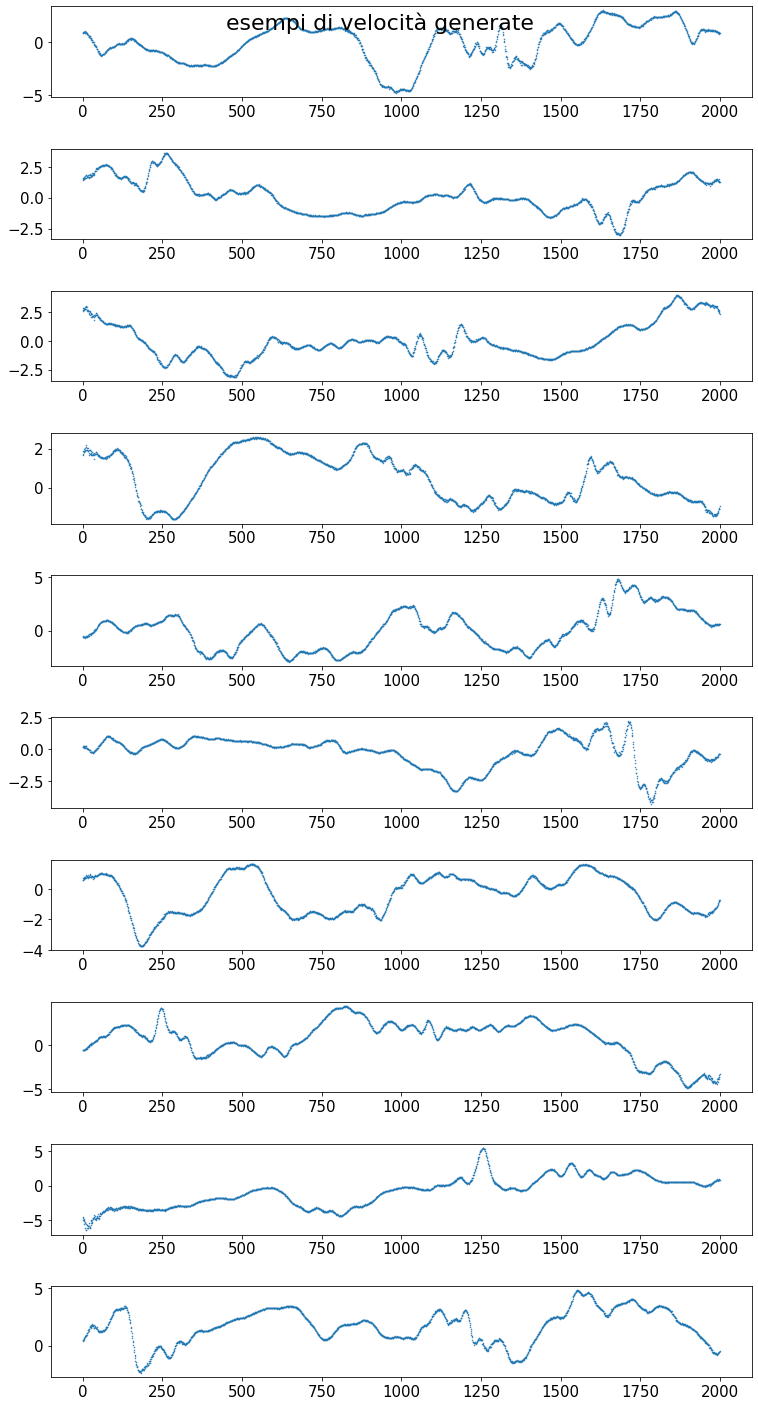

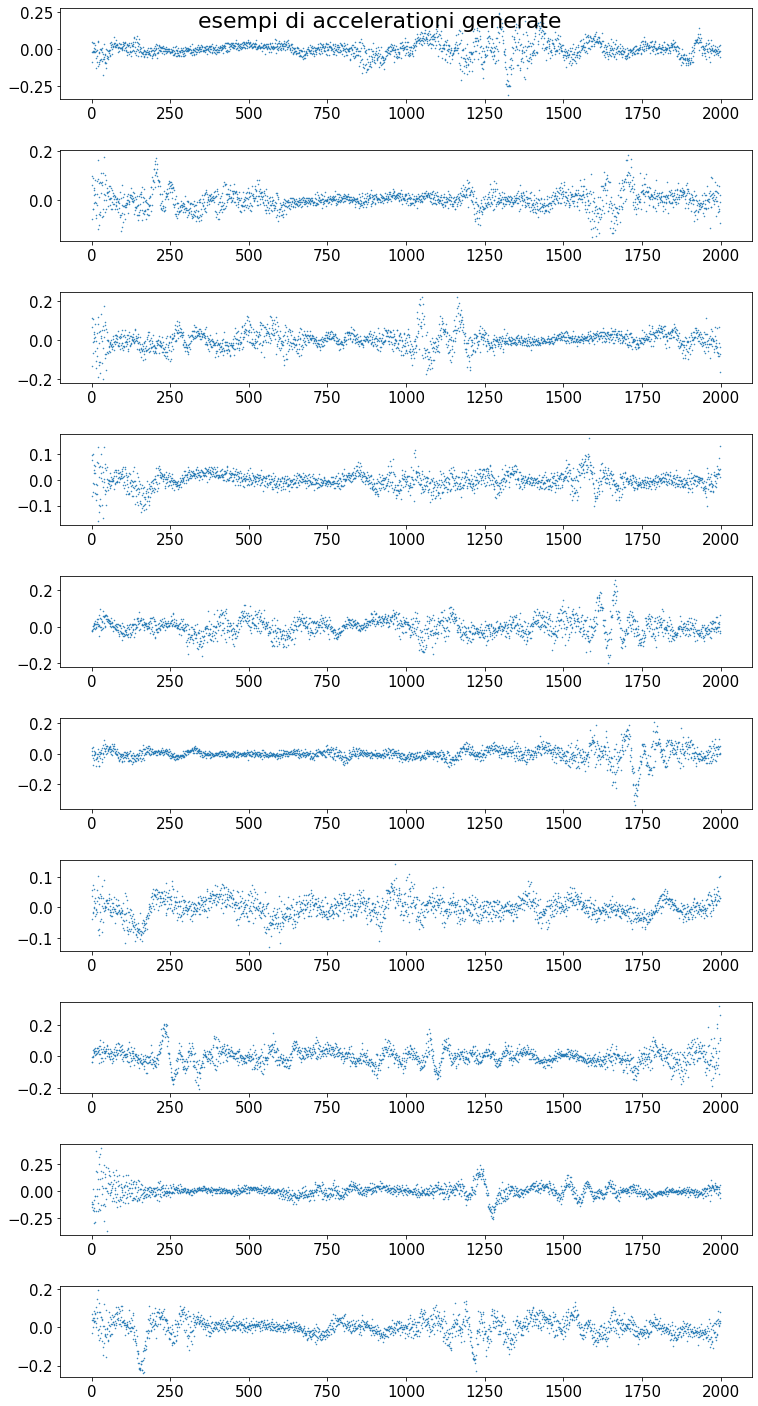

In [155]:
idx2 = np.random.randint(0, gen.shape[0],10)
print(idx2)
gen_trajs = gen[idx2]
plt.figure(figsize=(11,2*len(gen_trajs)))
plt.suptitle('esempi di velocità generate')

for i, traj in enumerate(gen_trajs):
    plt.subplot(len(gen_trajs), 1, i+1)
    plt.plot(traj, lw=0, marker='.',ms=1)

plt.tight_layout()
plt.savefig(f'plots/wgangp_{run}/gan_test_gen_vel_{run}_{number}.png', fmt='png', dpi=100)
plt.show()

gen_trajs = np.gradient(gen_trajs, axis=1)
plt.figure(figsize=(11,2*len(gen_trajs)))
plt.suptitle('esempi di accelerationi generate')

for i, traj in enumerate(gen_trajs):
    plt.subplot(len(gen_trajs), 1, i+1)
    plt.plot(traj, lw=0, marker='.',ms=1)

plt.tight_layout()
plt.savefig(f'plots/wgangp_{run}/gan_test_gen_acc_{run}_{number}.png', fmt='png', dpi=100)
plt.show()

In [156]:

plt.rcParams['font.size'] = 26
#plt.rcParams['axes.labelsize'] = 10
#plt.rcParams['axes.labelweight'] = 'bold'
#plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 22
plt.rcParams['figure.titlesize'] = 22
#plt.rcParams['image.cmap'] = 'jet'
#plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.markerscale'] = 4
plt.rcParams['lines.marker'] = '.'

# Provo a smoothare le velocità

In [121]:
#vel = gen[36350,:,0]
vel = gen[16772,:,0]
prova3 = np.zeros(shape=(2000))
prova3[0] = vel[0]
prova3[-1] = vel[-1]

prova5 = np.zeros(shape=(2000))
prova5[0] = vel[0]
prova5[1] = (vel[0] + vel[1] + vel[2])/3.
prova5[-1] = vel[-1]
prova5[-2] = (vel[-1] + vel[-2] + vel[-3])/3.

prova7 = np.zeros(shape=(2000))
prova7[0] = vel[0]
prova7[1] = (vel[0] + vel[1] + vel[2])/3.
prova7[2] = (vel[0] + vel[1] + vel[2] + vel[3] + vel[4])/5.
prova7[-1] = vel[-1]
prova7[-2] = (vel[-1] + vel[-2] + vel[-3])/3.
prova7[-3] = (vel[-1] + vel[-2] + vel[-3] + vel[-4] + vel[-5])/5.

for tt in range(1,gen.shape[1]-1):
    prova3[tt] = (vel[tt-1] + vel[tt] + vel[tt+1]) / 3.
    
for tt in range(2,gen.shape[1]-2):
    prova5[tt] = (vel[tt-2] + vel[tt-1] + vel[tt] + vel[tt+1] + vel[tt+2]) / 5.
    
for tt in range(3,gen.shape[1]-3):
    prova7[tt] = (vel[tt-3] + vel[tt-2] + vel[tt-1] + vel[tt] + vel[tt+1] + vel[tt+2] + vel[tt+3]) / 7.
    
delta = 0.4
#prova3 = prova3 - delta
#prova5 = prova5 - 2*delta
#prova7 = prova7 - 3*delta

In [124]:
def smooth(x,window_len=5,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    #if x.ndim != 1:
    #    raise ValueError, "smooth only accepts 1 dimension arrays."
#
    #if x.size < window_len:
    #    raise ValueError, "Input vector needs to be bigger than window size."
#
#
    #if window_len<3:
    #    return x
#
#
    #if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
    #    raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2):-(window_len//2)]

prova5 = smooth(vel,9)

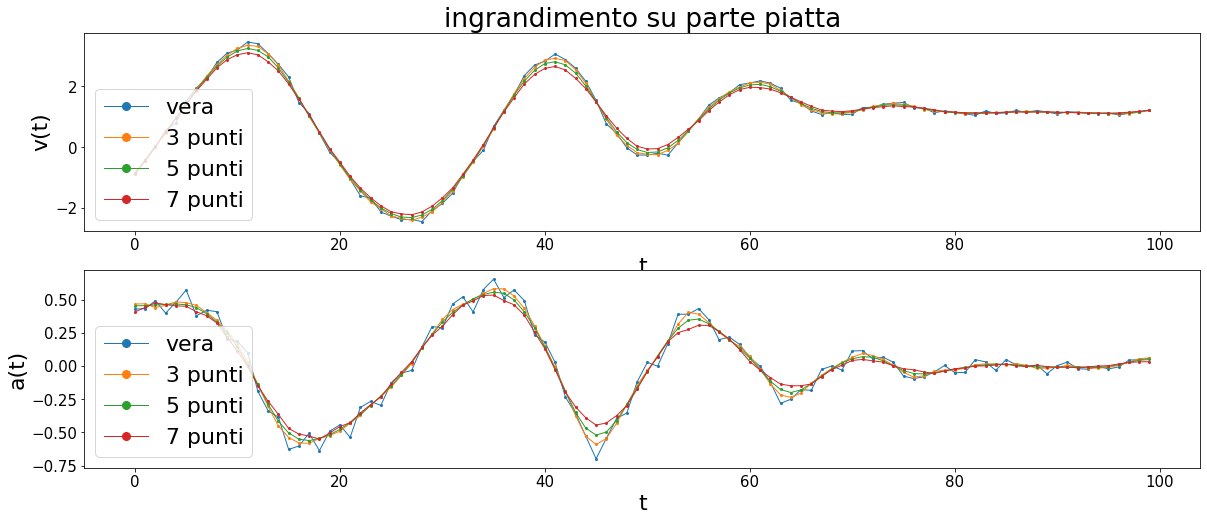

In [125]:
#start=1250
start=200
end=start+100
plt.subplot(2,1,1)
plt.title("ingrandimento su parte piatta")
#plt.title("ingrandimento su evento raro")
plt.plot(vel[start:end],label="vera")
plt.plot(prova3[start:end],label="3 punti")
plt.plot(prova5[start:end],label="5 punti")
plt.plot(prova7[start:end],label="7 punti")
plt.ylabel("v(t)")
plt.xlabel("t")
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.gradient(vel[start:end]),label="vera")
plt.plot(np.gradient(prova3[start:end]),label="3 punti")
plt.plot(np.gradient(prova5[start:end]),label="5 punti")
plt.plot(np.gradient(prova7[start:end]),label="7 punti")
plt.ylabel("a(t)")
plt.xlabel("t")
plt.legend()
plt.savefig("medie_a_x_punti",fmt="png",dpi=100)
plt.show()

In [92]:
gen5 = np.zeros(shape=50000)

for part in range(50000):
    
    if part%1000==0: print(part)
    gen5[part,0,0] = gen[part,0,0]
    gen5[part,1,0] = (gen[part,0,0] + gen[part,1,0] + gen[part,2,0])/3.
    gen5[part,-1,0] = gen[part,-1,0]
    gen5[part,-2,0] = (gen[part,-1,0] + gen[part,-2,0] + gen[part,-3,0])/3.

    for tt in range(2,gen.shape[1]-2):
        
        gen5[part,tt,0] = (gen[part,tt-2,0] + gen[part,tt-1,0] + gen[part,tt,0] + gen[part,tt+1,0] + gen[part,tt+2,0]) / 5.
        


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


In [100]:
gen5 = gen5[0:50000]
np.save(f"wgangp/runs/{run}/gen_trajs_{number}_5punti",gen5)

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


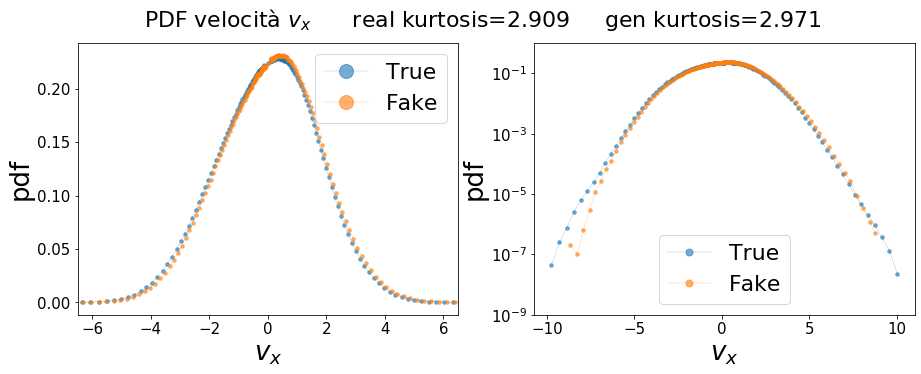

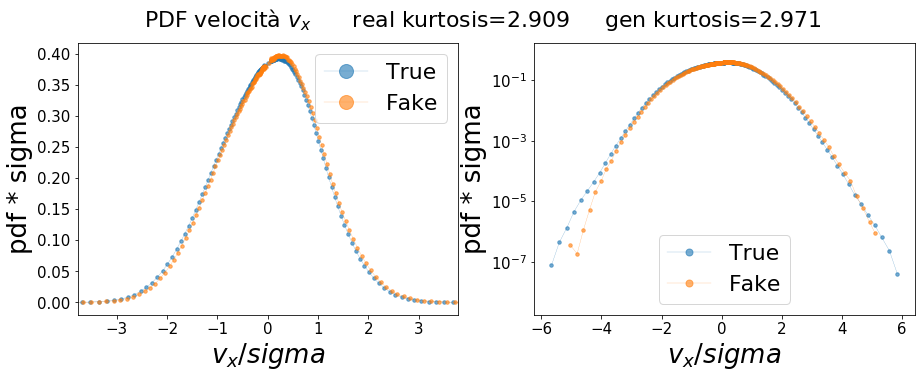

In [101]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fign, (ax1n, ax2n) = plt.subplots(1,2,figsize=(15,5))
hist, bin_edges = load_pdf('data/pdf_vx')
kurtosis_real = kurtosis(bin_edges, hist)
ax1.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
# normalizzate
vel_std = 1.7192559430218903
hist *= vel_std
bin_edges /= vel_std
ax1n.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2n.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)

bins=create_log_bins(gen5.min(),gen5.max(),200,1e-1)
hist, bin_edges = np.histogram(gen5.flatten(), bins=bins, density=True)
for i in range(len(hist)):
    bin_edges[i] = (bin_edges[i]+bin_edges[i+1])/2.
kurtosis_gen = kurtosis(bin_edges, hist)
bin_edges = bin_edges[:-1]
ax1.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
# normalizzate
hist *= vel_std
bin_edges /= vel_std
ax1n.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2n.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)

fig.suptitle(f'PDF velocità $v_x$\treal kurtosis={kurtosis_real:.3f}\tgen kurtosis={kurtosis_gen:.3f}')
fign.suptitle(f'PDF velocità $v_x$\treal kurtosis={kurtosis_real:.3f}\tgen kurtosis={kurtosis_gen:.3f}')

ax1.set_xlabel('$v_x$')
ax1.set_ylabel('pdf')
ax1.set_xlim([-6.5,6.5])
ax1.legend(markerscale=4)
ax2.set_xlabel('$v_x$')
ax2.set_yscale('log')
ax2.set_ylim([1e-9,1])
ax2.set_ylabel('pdf')
ax2.legend(markerscale=2)

ax1n.set_xlabel('$v_x / sigma$')
ax1n.set_ylabel('pdf * sigma')
ax1n.set_xlim([-6.5/vel_std,6.5/vel_std])
ax1n.legend(markerscale=4)
ax2n.set_xlabel('$v_x / sigma$')
ax2n.set_yscale('log')
ax2n.set_ylim([1e-9*vel_std,1*vel_std])
ax2n.set_ylabel('pdf * sigma')
ax2n.legend(markerscale=2)

#fig.savefig(f'plots/wgangp_{run}/gan_test_d0_{run}_{number}.png', fmt='png', dpi=100)
#fign.savefig(f'plots/wgangp_{run}/gan_test_d0_{run}_{number}_n.png', fmt='png', dpi=100)
fig.show()
fign.show()

In [102]:
gm = np.gradient(gen5,axis=1)

1.0017092626771908
1.0051709317388708


/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


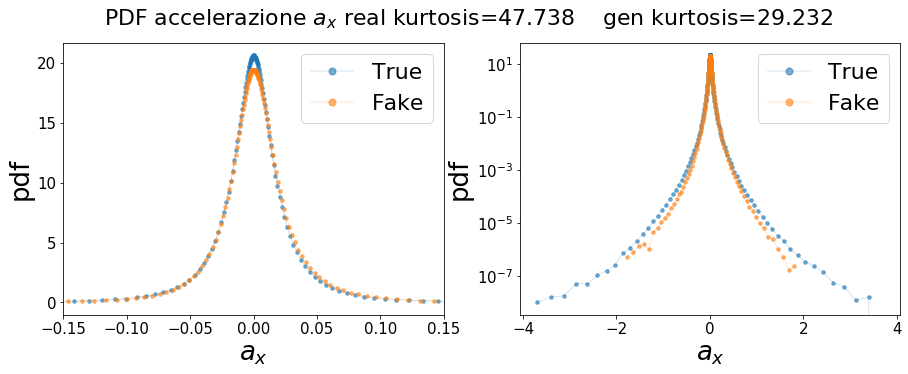

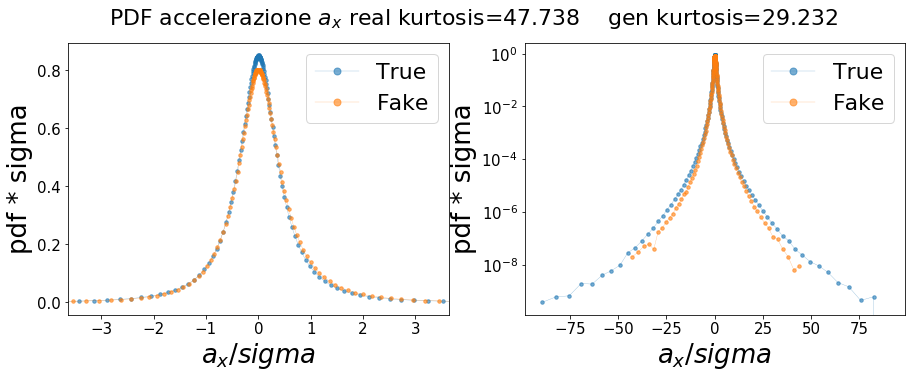

In [103]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fign, (ax1n, ax2n) = plt.subplots(1,2,figsize=(15,5))

hist, bin_edges = load_pdf('data/pdf_ax')
a = 0.
for i in range(len(bin_edges)-1):
    a += hist[i]*(bin_edges[i+1]-bin_edges[i])
print(a)
kurtosis_real = kurtosis(bin_edges, hist)
ax1.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
# normalizzate
acc_std = 0.0412815564714219
hist = hist * acc_std
bin_edges = bin_edges / acc_std
ax1n.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2n.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)

bins=create_log_bins(gm.min(),gm.max(),200,1e-3)
hist, bin_edges = np.histogram(gm.flatten(), bins=bins, density=True)
for i in range(len(hist)):
    bin_edges[i] = (bin_edges[i]+bin_edges[i+1])/2.
kurtosis_gen = kurtosis(bin_edges, hist)
bin_edges = bin_edges[:-1]
a = 0.
for i in range(len(bin_edges)-1):
    a += hist[i]*(bin_edges[i+1]-bin_edges[i])
print(a)
ax1.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
# normalizzate
hist = hist * acc_std
bin_edges = bin_edges / acc_std
ax1n.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2n.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)

fig.suptitle(f'PDF accelerazione $a_x$\treal kurtosis={kurtosis_real:.3f}\tgen kurtosis={kurtosis_gen:.3f}')
fign.suptitle(f'PDF accelerazione $a_x$\treal kurtosis={kurtosis_real:.3f}\tgen kurtosis={kurtosis_gen:.3f}')

ax1.legend(markerscale=2)
ax1.set_xlabel('$a_x$')
ax1.set_ylabel('pdf')
ax1.set_xlim([-0.15,0.15])
ax2.legend(markerscale=2)
ax2.set_xlabel('$a_x$')
ax2.set_ylabel('pdf')
ax2.set_yscale('log')

ax1n.legend(markerscale=2)
ax1n.set_xlabel('$a_x / sigma$')
ax1n.set_ylabel('pdf * sigma')
ax1n.set_xlim([-0.15/acc_std,0.15/acc_std])
ax2n.legend(markerscale=2)
ax2n.set_xlabel('$a_x / sigma$')
ax2n.set_ylabel('pdf * sigma')
ax2n.set_yscale('log')

#fig.savefig(f'plots/wgangp_{run}/gan_test_d1_{run}_{number}.png', fmt='png', dpi=100)
#fign.savefig(f'plots/wgangp_{run}/gan_test_d1_{run}_{number}_n.png', fmt='png', dpi=100)
fig.show()
fign.show()

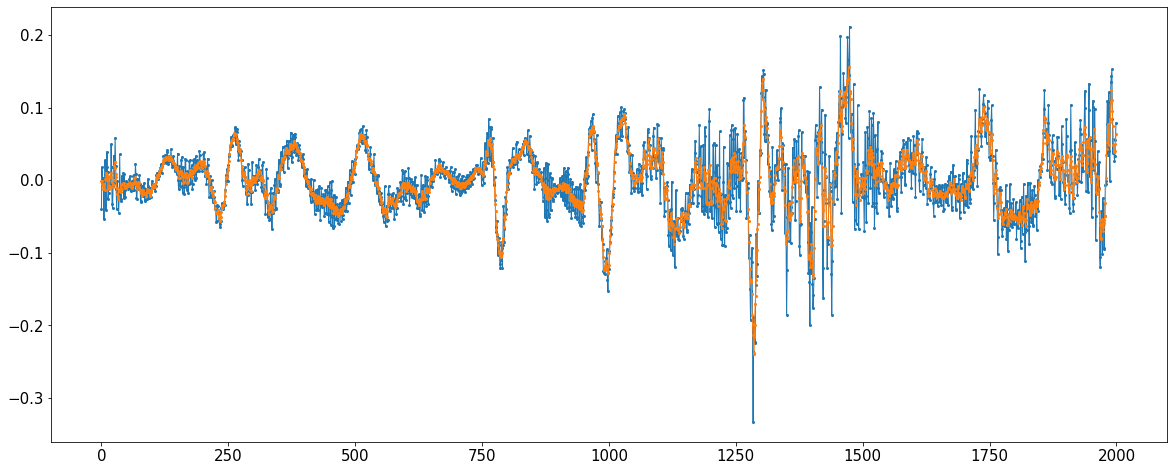

In [107]:
plt.plot(np.gradient(gen[0],axis=0))
plt.plot(np.gradient(gen5[0],axis=0))

In [157]:
gen9 = np.zeros(shape=(50000,2000,1))

for part in range(50000):
    
    if part%1000==0: print(part)
    gen9[part,:,0] = smooth(gen[part,:,0],9,'hanning')
        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


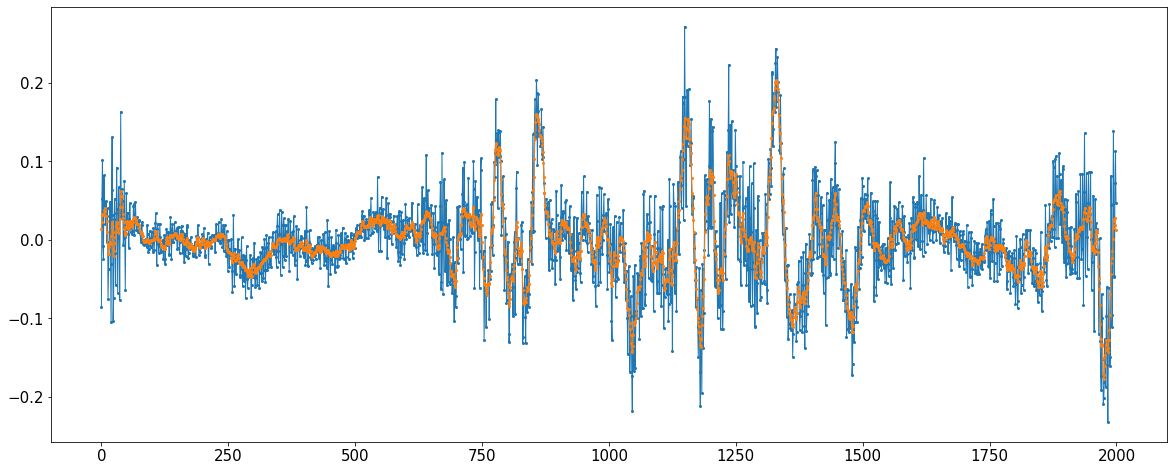

In [158]:
plt.plot(np.gradient(gen[0],axis=0))
plt.plot(np.gradient(gen9[0],axis=0))

In [130]:
gen9[0]

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


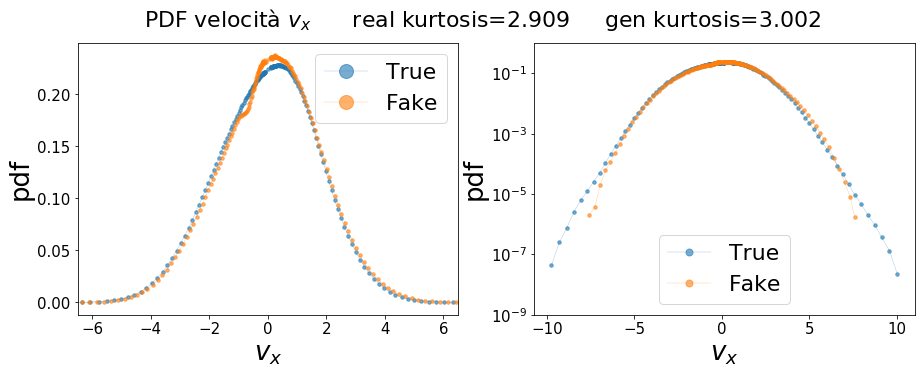

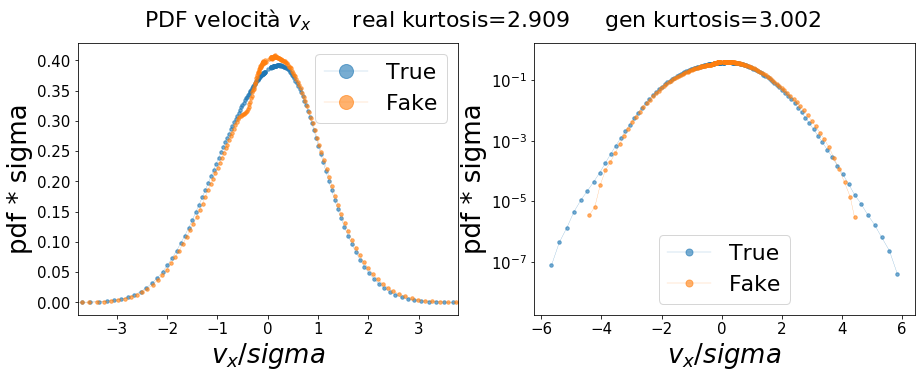

In [159]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fign, (ax1n, ax2n) = plt.subplots(1,2,figsize=(15,5))
hist, bin_edges = load_pdf('data/pdf_vx')
kurtosis_real = kurtosis(bin_edges, hist)
ax1.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
# normalizzate
vel_std = 1.7192559430218903
hist *= vel_std
bin_edges /= vel_std
ax1n.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2n.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)

bins=create_log_bins(gen9.min(),gen9.max(),200,1e-1)
hist, bin_edges = np.histogram(gen9.flatten(), bins=bins, density=True)
for i in range(len(hist)):
    bin_edges[i] = (bin_edges[i]+bin_edges[i+1])/2.
kurtosis_gen = kurtosis(bin_edges, hist)
bin_edges = bin_edges[:-1]
ax1.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
# normalizzate
hist *= vel_std
bin_edges /= vel_std
ax1n.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2n.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)

fig.suptitle(f'PDF velocità $v_x$\treal kurtosis={kurtosis_real:.3f}\tgen kurtosis={kurtosis_gen:.3f}')
fign.suptitle(f'PDF velocità $v_x$\treal kurtosis={kurtosis_real:.3f}\tgen kurtosis={kurtosis_gen:.3f}')

ax1.set_xlabel('$v_x$')
ax1.set_ylabel('pdf')
ax1.set_xlim([-6.5,6.5])
ax1.legend(markerscale=4)
ax2.set_xlabel('$v_x$')
ax2.set_yscale('log')
ax2.set_ylim([1e-9,1])
ax2.set_ylabel('pdf')
ax2.legend(markerscale=2)

ax1n.set_xlabel('$v_x / sigma$')
ax1n.set_ylabel('pdf * sigma')
ax1n.set_xlim([-6.5/vel_std,6.5/vel_std])
ax1n.legend(markerscale=4)
ax2n.set_xlabel('$v_x / sigma$')
ax2n.set_yscale('log')
ax2n.set_ylim([1e-9*vel_std,1*vel_std])
ax2n.set_ylabel('pdf * sigma')
ax2n.legend(markerscale=2)

#fig.savefig(f'plots/wgangp_{run}/gan_test_d0_{run}_{number}.png', fmt='png', dpi=100)
#fign.savefig(f'plots/wgangp_{run}/gan_test_d0_{run}_{number}_n.png', fmt='png', dpi=100)
fig.show()
fign.show()

In [160]:
gm = np.gradient(gen9,axis=1)

1.0017092626771908
1.0074489596357563


/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


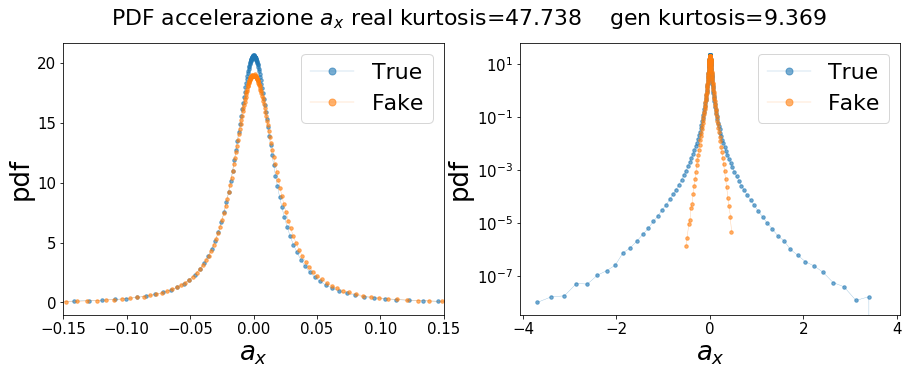

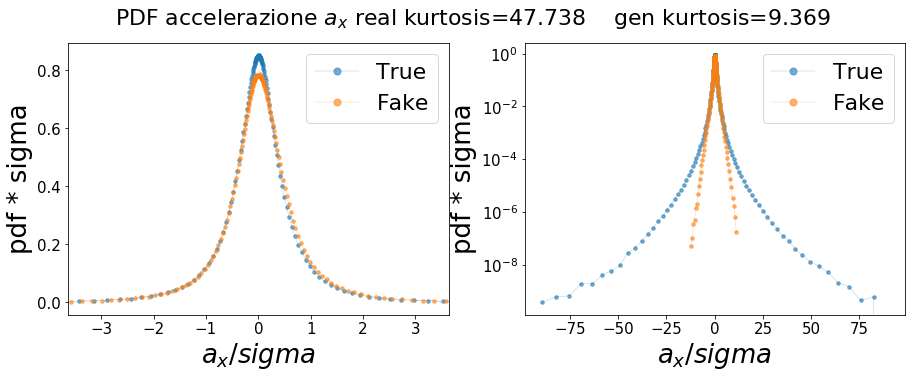

In [161]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fign, (ax1n, ax2n) = plt.subplots(1,2,figsize=(15,5))

hist, bin_edges = load_pdf('data/pdf_ax')
a = 0.
for i in range(len(bin_edges)-1):
    a += hist[i]*(bin_edges[i+1]-bin_edges[i])
print(a)
kurtosis_real = kurtosis(bin_edges, hist)
ax1.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
# normalizzate
acc_std = 0.0412815564714219
hist = hist * acc_std
bin_edges = bin_edges / acc_std
ax1n.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2n.plot(bin_edges, hist, label='True', alpha=0.6, marker='.', lw=0.3, ms=7)

bins=create_log_bins(gm.min(),gm.max(),200,1e-3)
hist, bin_edges = np.histogram(gm.flatten(), bins=bins, density=True)
for i in range(len(hist)):
    bin_edges[i] = (bin_edges[i]+bin_edges[i+1])/2.
kurtosis_gen = kurtosis(bin_edges, hist)
bin_edges = bin_edges[:-1]
a = 0.
for i in range(len(bin_edges)-1):
    a += hist[i]*(bin_edges[i+1]-bin_edges[i])
print(a)
ax1.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
# normalizzate
hist = hist * acc_std
bin_edges = bin_edges / acc_std
ax1n.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)
ax2n.plot(bin_edges, hist, label='Fake', alpha=0.6, marker='.', lw=0.3, ms=7)

fig.suptitle(f'PDF accelerazione $a_x$\treal kurtosis={kurtosis_real:.3f}\tgen kurtosis={kurtosis_gen:.3f}')
fign.suptitle(f'PDF accelerazione $a_x$\treal kurtosis={kurtosis_real:.3f}\tgen kurtosis={kurtosis_gen:.3f}')

ax1.legend(markerscale=2)
ax1.set_xlabel('$a_x$')
ax1.set_ylabel('pdf')
ax1.set_xlim([-0.15,0.15])
ax2.legend(markerscale=2)
ax2.set_xlabel('$a_x$')
ax2.set_ylabel('pdf')
ax2.set_yscale('log')

ax1n.legend(markerscale=2)
ax1n.set_xlabel('$a_x / sigma$')
ax1n.set_ylabel('pdf * sigma')
ax1n.set_xlim([-0.15/acc_std,0.15/acc_std])
ax2n.legend(markerscale=2)
ax2n.set_xlabel('$a_x / sigma$')
ax2n.set_ylabel('pdf * sigma')
ax2n.set_yscale('log')

#fig.savefig(f'plots/wgangp_{run}/gan_test_d1_{run}_{number}.png', fmt='png', dpi=100)
#fign.savefig(f'plots/wgangp_{run}/gan_test_d1_{run}_{number}_n.png', fmt='png', dpi=100)
fig.show()
fign.show()